In [1]:
import os
#os.environ['OMP_NUM_THREADS'] = os.environ.get('SLURM_CPUS_PER_TASK','1')
print(f'OMP_NUM_THREADS={os.environ.get('OMP_NUM_THREADS')}')
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import warnings
from dask.distributed import LocalCluster, Client, progress
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
#pbar.register()
import datetime
import flox 
import xarray as xr

# local modules
from load_SAIdata import Cases
import physics
import interpolate
import tracks
%matplotlib inline

OMP_NUM_THREADS=None


The cell contents below are used in `TCs-under-SAI/analysis/jobs/windshear/windshear.py`

In [12]:
%%time

tslices = {  # analysis periods, inclusive
    'ref': slice('2003','2007'), 
    'cnt': slice('2093','2097'), 
    'sai': slice('2093','2097')
}


def array_job_id_to_case(i):
    """generate case tag for SLURM array job id"""
    return [case for case in Cases.cases if 'hres.' in case][i]


def center_timestamps(ds):
    """center timestamps in their interval given by time_bnds"""
    # only compute the centered time from time_bnds on the first step,
    # as computing it on all steps is quite slow
    citime = ds.time_bnds[0].mean('nbnd').compute() # centered initial time
    dsec = (citime - ds.time[0]).dt.total_seconds().item()
    dtshift = datetime.timedelta(seconds=dsec)
    ds['time'] = ds.time + dtshift
    return ds


def get_timestep(ds):
    """Get timestep in days"""
    dt = (ds.time[1] - ds.time[0]).dt.total_seconds().item()
    return dt/86400


def open_ds_3h_atm(exp, ens, center_time=True, **kwargs):
    """open 3-hourly atmospheric dataset for one ensemble member"""
    # file stream corresponding to 3-hourly data
    if (exp in ['ref','cnt']) and (int(ens) in range(1,6)):
        stream = 'h1'
    else:
        stream = 'h5'

    ds = (
        Cases(f'hres.{exp}.{ens}')
        .select('atm',stream)
        .open_mfdataset(**kwargs)
        .assign_coords(exp=exp, ens=int(ens))
    )

    if center_time:
        ds = center_timestamps(ds)

    return ds


def main():
    arrjobid = os.environ['SLURM_ARRAY_TASK_ID']
    tag = array_job_id_to_case(arrjobid)
    print(f'{tag=}')
    _,exp,ens = tag.split('.')
    ds = open_ds_3h_atm(exp, ens)
    ds = ds.sel(time=tslices[exp])

    # monthly mean VWS
    VWS = physics.windshear_250_850(ds)
    VWSmonmean = VWS.resample(time='1MS').mean().groupby('time.month').mean()
    
    # monthly mean days with low VWS
    dt = get_timestep(ds)
    VWSdays = (VWS <= 12.5) * dt
    VWSdays = VWSdays.resample(time='1MS').sum().groupby('time.month').mean()
    VWSdays = VWSdays.astype('float32').assign_attrs({
        'long_name': 'number of days having at most 12.5 m/s wind shear'})

    outname = f'{../../data/VWS.{tag}.nc'
    out = xr.Dataset({'VWS': VWSmonmean, 'lowVWSdays': VWSdays})
    print(f'writing to {outname}')
    out.to_netcdf(outname)
    return

if __name__ == '__main__':
    main()

Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e10.B_RCP8.5_CO2_CAM5.f02_t12.started_2002-12.002.cam2.h1.2002-12-01-10800_2007-12-31-10800.json
[########################################] | 100% Completed | 101.39 ms
[########################################] | 100% Completed | 101.70 ms
writing to /scratch-local/jasperdj.18491515/VWS.hres.ref.2.nc
[########################################] | 100% Completed | 512.44 s
CPU times: user 31min 17s, sys: 6min 51s, total: 38min 9s
Wall time: 8min 55s


In [2]:
ds = xr.concat([xr.open_mfdataset(f'../data/VWS.hres.{exp}.?.nc', combine='nested', concat_dim='ens') for exp in ['ref','cnt','sai']], dim='exp')
ds = ds.mean('ens', keep_attrs=True)
ds['dpm'] = ('month', [31,28,31,30,31,30,31,31,30,31,30,31], {'long_name':'days per month'})
ds.to_netcdf('../data/VWS.nc')

### Plotting

In [2]:
ds = xr.open_dataset('../data/VWS.nc')

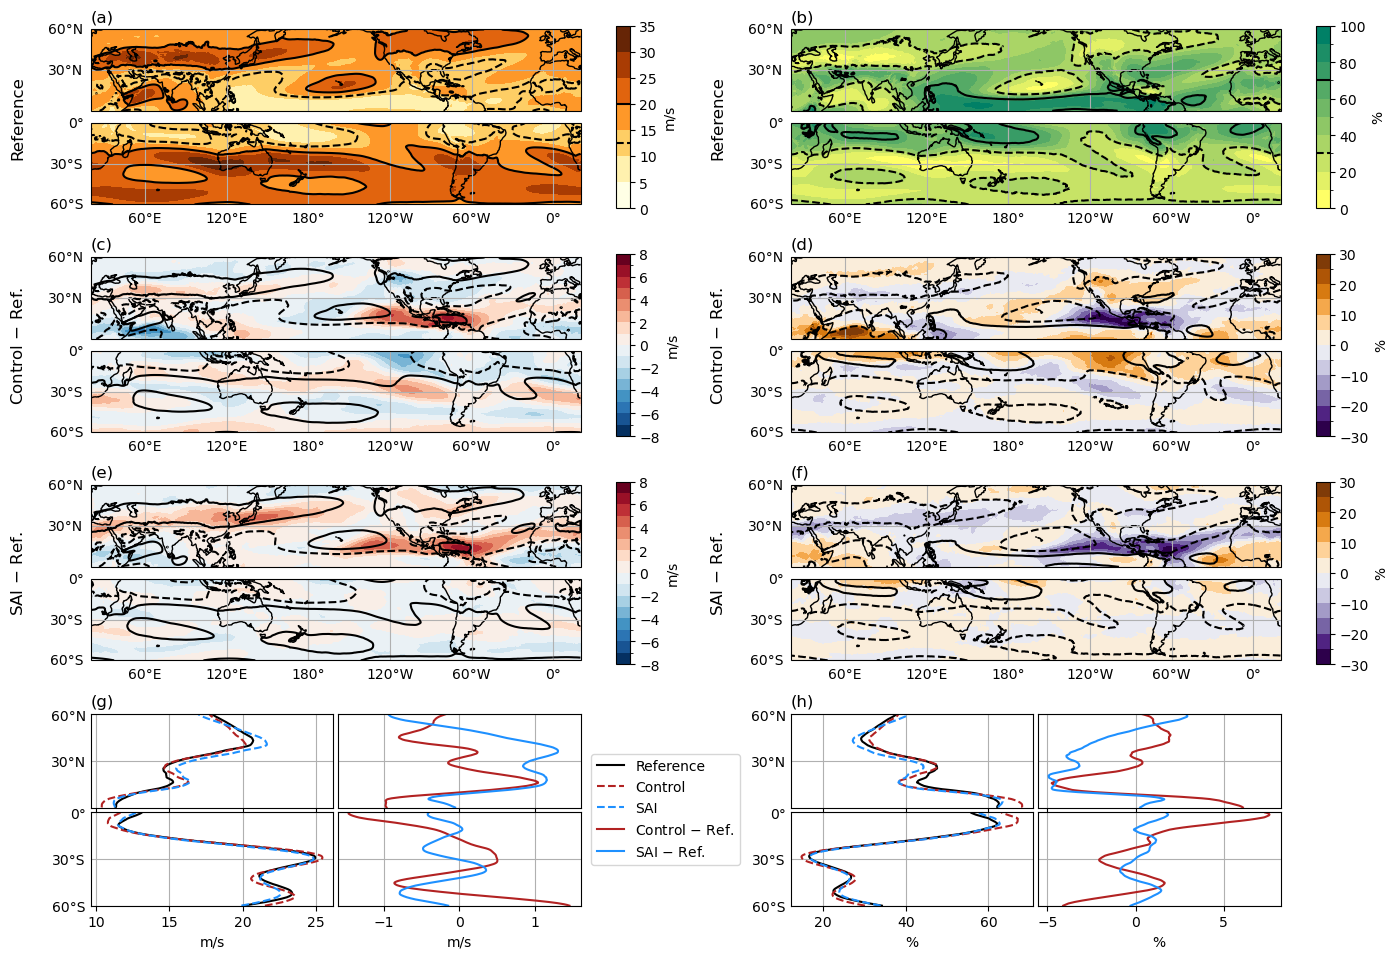

In [7]:
VWS_NH = ds.VWS.sel(month=[6,7,8,9,10], lat=slice(0,60)).weighted(ds.dpm).mean('month')
VWS_SH = ds.VWS.sel(month=[1,2,3,4,5], lat=slice(-60,0)).weighted(ds.dpm).mean('month')
days_NH = ds.lowVWSdays.sel(month=[6,7,8,9,10], lat=slice(0,60)).sum('month') / ds.dpm.sel(month=[6,7,8,9,10]).sum('month') * 100
days_SH = ds.lowVWSdays.sel(month=[1,2,3,4,5], lat=slice(-60,0)).sum('month') / ds.dpm.sel(month=[1,2,3,4,5]).sum('month') * 100

fig = plt.figure(figsize=(14, 0.6125*14+1))
subfigs = fig.subfigures(2, 1, hspace=0.0, height_ratios=[3, 1.2])
mapfigs = subfigs[0].subfigures(3,2,hspace=0, wspace=0)
zmfigs = subfigs[1].subfigures(1,2,wspace=0)

# for m,mfig in enumerate(mapfigs[:,0]):
    #mfig.text(0.01,0.5,['Reference','Control $-$ Ref.', 'SAI $-$ Ref.'][m], va='center', rotation=90)
    # mfig.supylabel(['Reference','Control $-$ Ref.', 'SAI $-$ Ref.'][m], x=0.01)

for m,mfig in enumerate(mapfigs.flatten()):
    # mfig.set_edgecolor('k')
    # mfig.set_linewidth(.01)
    axt, axb = mfig.subplots(2,1, sharex=True, subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})
    axt.coastlines()
    axb.coastlines()
    axb.gridlines(draw_labels=['left','bottom'],ylocs=[0,-30,-60], )
    axt.gridlines(draw_labels=['left'], ylocs=[0,30,60])
    axt.set_extent((20,380,0,60.0000001), crs=ccrs.PlateCarree())
    axb.set_extent((20,380,-60.0000001,0.0000001), crs=ccrs.PlateCarree())
    #cf = axt.contourf([60,300],[20,50],[[1,1],[2,2]], transform=ccrs.PlateCarree())
    mfig.subplots_adjust(left=0.125, right=0.825, top=0.9, bottom=0.1, hspace=0.05)
    cbtax = mfig.add_axes((0.875,0.1,0.02,0.8))
    #mfig.colorbar(cf, cax=cbtax, label='m/s')
    axt.set_title(f'({'abcdef'[m]})', loc='left')
    mfig.supylabel(['Reference','Control $-$ Ref.', 'SAI $-$ Ref.'][m//2], x=0.01)

lvls_days = np.linspace(0,100,11) # color levels lowVWSdays
lvls_Ddays = np.linspace(-30,30,13) # color levels lowVWSdays anomalies
lvls_VWS = np.linspace(0,35,8) # color levels VWS
lvls_DVWS = np.linspace(-8,8,17) # color levels VWS anomalies
clvls_VWS = [12.5,20]
clvls_days = [30,70]

axes = mapfigs[0,0].axes # upper left: Reference VWS
cf000 = VWS_NH.sel(exp='ref').plot.contourf(ax=axes[0], add_colorbar=False, transform=ccrs.PlateCarree(), levels=lvls_VWS, extend='neither', cmap='YlOrBr')
cs000 = VWS_NH.sel(exp='ref').plot.contour(ax=axes[0], add_colorbar=False, transform=ccrs.PlateCarree(), levels=clvls_VWS, linestyles=['--','-'], colors='k')
cf001 = VWS_SH.sel(exp='ref').plot.contourf(ax=axes[1], cbar_kwargs={'cax':axes[2], 'label':'m/s'}, transform=ccrs.PlateCarree(), levels=lvls_VWS, cmap='YlOrBr')
cs001 = VWS_SH.sel(exp='ref').plot.contour(ax=axes[1], add_colorbar=False, transform=ccrs.PlateCarree(), levels=clvls_VWS, linestyles=['--','-'], colors='k')
[axes[2].axhline(c, ls=ls, c='k') for (c,ls) in zip(cs000.get_clim(), ['--','-'])]

axes = mapfigs[1,0].axes # center left: Control - Ref VWS
cf100 = (VWS_NH.sel(exp='cnt')-VWS_NH.sel(exp='ref')).plot.contourf(ax=axes[0], add_colorbar=False, transform=ccrs.PlateCarree(), levels=lvls_DVWS, extend='neither', cmap='RdBu_r')
cs100 = VWS_NH.sel(exp='cnt').plot.contour(ax=axes[0], add_colorbar=False, transform=ccrs.PlateCarree(), levels=clvls_VWS, linestyles=['--','-'], colors='k')
cf101 = (VWS_SH.sel(exp='cnt')-VWS_SH.sel(exp='ref')).plot.contourf(ax=axes[1], cbar_kwargs={'cax':axes[2], 'label':'m/s'}, transform=ccrs.PlateCarree(), levels=lvls_DVWS, cmap='RdBu_r')
cs101 = VWS_SH.sel(exp='cnt').plot.contour(ax=axes[1], add_colorbar=False, transform=ccrs.PlateCarree(), levels=clvls_VWS, linestyles=['--','-'], colors='k')
[axes[2].axhline(c, ls=ls, c='k') for (c,ls) in zip(cs100.get_clim(), ['--','-'])]

axes = mapfigs[2,0].axes # bottom left: SAI - Ref VWS
cf200 = (VWS_NH.sel(exp='sai')-VWS_NH.sel(exp='ref')).plot.contourf(ax=axes[0], add_colorbar=False, transform=ccrs.PlateCarree(), levels=lvls_DVWS, extend='neither', cmap='RdBu_r')
cs200 = VWS_NH.sel(exp='sai').plot.contour(ax=axes[0], add_colorbar=False, transform=ccrs.PlateCarree(), levels=clvls_VWS, linestyles=['--','-'], colors='k')
cf201 = (VWS_SH.sel(exp='sai')-VWS_SH.sel(exp='ref')).plot.contourf(ax=axes[1], cbar_kwargs={'cax':axes[2], 'label':'m/s'}, transform=ccrs.PlateCarree(), levels=lvls_DVWS, cmap='RdBu_r')
cs201 = VWS_SH.sel(exp='sai').plot.contour(ax=axes[1], add_colorbar=False, transform=ccrs.PlateCarree(), levels=clvls_VWS, linestyles=['--','-'], colors='k')
[axes[2].axhline(c, ls=ls, c='k') for (c,ls) in zip(cs200.get_clim(), ['--','-'])]

axes = mapfigs[0,1].axes # upper right: Reference VWSdays
cf010 = days_NH.sel(exp='ref').plot.contourf(ax=axes[0], add_colorbar=False, transform=ccrs.PlateCarree(), levels=lvls_days, extend='neither', cmap='summer_r')
cs010 = days_NH.sel(exp='ref').plot.contour(ax=axes[0], add_colorbar=False, transform=ccrs.PlateCarree(), levels=clvls_days, linestyles=['--','-'], colors='k')
cf011 = days_SH.sel(exp='ref').plot.contourf(ax=axes[1], cbar_kwargs={'cax':axes[2], 'label':'%'}, transform=ccrs.PlateCarree(), levels=lvls_days, extend='neither', cmap='summer_r')
cs011 = days_SH.sel(exp='ref').plot.contour(ax=axes[1], add_colorbar=False, transform=ccrs.PlateCarree(), levels=clvls_days, linestyles=['--','-'], colors='k')
[axes[2].axhline(c, ls=ls, c='k') for (c,ls) in zip(cs010.get_clim(), ['--','-'])]

axes = mapfigs[1,1].axes # center right: Control - Ref VWSdays
cf110 = (days_NH.sel(exp='cnt')-days_NH.sel(exp='ref')).plot.contourf(ax=axes[0], add_colorbar=False, transform=ccrs.PlateCarree(), levels=lvls_Ddays, extend='neither', cmap='PuOr_r')
cs110 = days_NH.sel(exp='cnt').plot.contour(ax=axes[0], add_colorbar=False, transform=ccrs.PlateCarree(), levels=clvls_days, linestyles=['--','-'], colors='k')
cf111 = (days_SH.sel(exp='cnt')-days_SH.sel(exp='ref')).plot.contourf(ax=axes[1], cbar_kwargs={'cax':axes[2], 'label':'%'}, transform=ccrs.PlateCarree(), levels=lvls_Ddays, cmap='PuOr_r')
cs111 = days_SH.sel(exp='cnt').plot.contour(ax=axes[1], add_colorbar=False, transform=ccrs.PlateCarree(), levels=clvls_days, linestyles=['--','-'], colors='k')

axes = mapfigs[2,1].axes # bottom right: SAI - Ref VWSdays
cf210 = (days_NH.sel(exp='sai')-days_NH.sel(exp='ref')).plot.contourf(ax=axes[0], add_colorbar=False, transform=ccrs.PlateCarree(), levels=lvls_Ddays, extend='neither', cmap='PuOr_r')
cs210 = days_NH.sel(exp='sai').plot.contour(ax=axes[0], add_colorbar=False, transform=ccrs.PlateCarree(), levels=clvls_days, linestyles=['--','-'], colors='k')
cf211 = (days_SH.sel(exp='sai')-days_SH.sel(exp='ref')).plot.contourf(ax=axes[1], cbar_kwargs={'cax':axes[2], 'label':'%'}, transform=ccrs.PlateCarree(), levels=lvls_Ddays, cmap='PuOr_r')
cs211 = days_SH.sel(exp='sai').plot.contour(ax=axes[1], add_colorbar=False, transform=ccrs.PlateCarree(), levels=clvls_days, linestyles=['--','-'], colors='k')

for m,mfig in enumerate(mapfigs.flatten()):
    for ax in mfig.axes[:2]:
        ax.set_title('')
        ax.set_xlabel('')
        ax.set_ylabel('')

for z,zfig in enumerate(zmfigs.flatten()):
    axs = zfig.subplots(2,2, sharey='row', sharex='col')
    zfig.subplots_adjust(left=0.125, right=0.825, top=0.9, bottom=0.2, wspace=0.05/3)
    for ax in axs[0,:]:
        ax.set_ylim([0,60])
        ax.yaxis.set_tick_params(length=0)
    for ax in axs[1,:]:
        ax.set_ylim([-60,0])
        ax.yaxis.set_tick_params(length=0)
    axs[0,0].set_yticks([30,60], labels=['30°N','60°N'])
    axs[1,0].set_yticks([-60,-30,0], labels=['60°S','30°S','0°'])
    
for z,zfig in enumerate(zmfigs.flatten()):
    zfig.axes[0].set_title(f'({"gh"[z]})', loc='left')
    data_NH = [VWS_NH, days_NH][z]
    data_SH = [VWS_SH, days_SH][z]
    data_NH.sel(exp='ref').mean('lon').plot(ax=zfig.axes[0], y='lat', c='k', label='Reference')
    data_NH.sel(exp='cnt').mean('lon').plot(ax=zfig.axes[0], y='lat', c='firebrick', ls='--', label='Control')
    data_NH.sel(exp='sai').mean('lon').plot(ax=zfig.axes[0], y='lat', c='dodgerblue', ls='--', label='SAI')
    
    (data_NH.sel(exp='cnt').mean('lon')
     -data_NH.sel(exp='ref').mean('lon')).plot(ax=zfig.axes[1], y='lat', c='firebrick', label='Control $-$ Ref.')
    (data_NH.sel(exp='sai').mean('lon')
     -data_NH.sel(exp='ref').mean('lon')).plot(ax=zfig.axes[1], y='lat', c='dodgerblue', label='SAI $-$ Ref.')
    
    data_SH.sel(exp='ref').mean('lon').plot(ax=zfig.axes[2], y='lat', c='k', label='Reference')
    data_SH.sel(exp='cnt').mean('lon').plot(ax=zfig.axes[2], y='lat', c='firebrick', ls='--', label='Control')
    data_SH.sel(exp='sai').mean('lon').plot(ax=zfig.axes[2], y='lat', c='dodgerblue', ls='--', label='SAI')
    
    (data_SH.sel(exp='cnt').mean('lon')
     -data_SH.sel(exp='ref').mean('lon')).plot(ax=zfig.axes[3], y='lat', c='firebrick', label='Control $-$ Ref.')
    (data_SH.sel(exp='sai').mean('lon')
     -data_SH.sel(exp='ref').mean('lon')).plot(ax=zfig.axes[3], y='lat', c='dodgerblue', label='SAI $-$ Ref.')

han1, lab1 = zmfigs[0].axes[0].get_legend_handles_labels()
han2, lab2 = zmfigs[0].axes[1].get_legend_handles_labels()
zmfigs[0].legend(han1+han2, lab1+lab2, loc=(0.84,0.35))

zmfigs[0].axes[2].set_xlabel('m/s')
zmfigs[0].axes[3].set_xlabel('m/s')
zmfigs[1].axes[2].set_xlabel('%')
zmfigs[1].axes[3].set_xlabel('%')

for zfig in zmfigs:
    # zfig.set_edgecolor('k')
    # zfig.set_linewidth(.01)
    for ax in zfig.axes:
        ax.yaxis.set_tick_params(length=0)
        ax.set_title('')
        ax.set_ylabel('')
        ax.grid()

fig.savefig('../figures/VWS.TCseason.pdf', transparent=True, bbox_inches='tight')

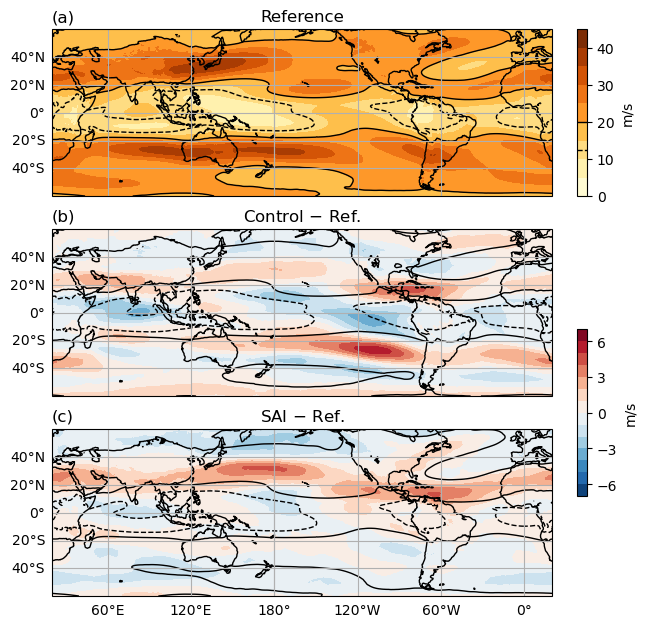

In [3]:
data = ds.VWS.sel(lat=slice(-60,60)).weighted(ds.dpm).mean('month')
fig, axs = plt.subplots(3, 1, figsize=(5,3.4/3*5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})
axs = axs.flatten()
for i,exp in enumerate(data.exp):
    datai = data.sel(exp=exp)
    if i > 0:
        cf = axs[i].contourf(datai.lon, datai.lat, datai-data.sel(exp='ref'), 
            transform=ccrs.PlateCarree(), levels=range(-7,8,1), cmap='RdBu_r')
    else:
        cfr = axs[i].contourf(datai.lon, datai.lat, datai, 
            transform=ccrs.PlateCarree(), levels=range(0,46,5), cmap='YlOrBr')
    cs = axs[i].contour(datai.lon, datai.lat, datai, transform=ccrs.PlateCarree(), levels=[12.5,20], colors='k', linewidths=1, linestyles=['--','-'])
    cl = axs[i].coastlines()
    gl = axs[i].gridlines(draw_labels=(['left'] if i<2 else ['left','bottom']))
    axs[i].set_title({'ref':'Reference','cnt':'Control $-$ Ref.','sai':'SAI $-$ Ref.'}[exp.item()])
    axs[i].set_title(['(a)','(b)','(c)'][i], loc='left')
    axs[i].set_extent((20,380,-60,60), crs=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0, top=1, left=0, right=1,
                    wspace=0.2, hspace=0.2)
cbr_ax = fig.add_axes([1.05, 1-1/3.4, 0.02, 1/3.4])
cb_ax = fig.add_axes([1.05, 0.6/3.4, 0.02, 1/3.4])
cbr = fig.colorbar(cfr, cax=cbr_ax, ticks=range(0,41,10), label='m/s')
cb = fig.colorbar(cf, cax=cb_ax, ticks=range(-6,7,3), shrink=0.5, label='m/s')
cbr_ax.axhline(12.5, c='k', lw=1, ls='--')
cbr_ax.axhline(20, c='k', lw=1)

fig.suptitle('annual mean VWS', y=1.1)
fig.savefig('../figures/VWS.annualmean.pdf', transparent=True, bbox_inches='tight')

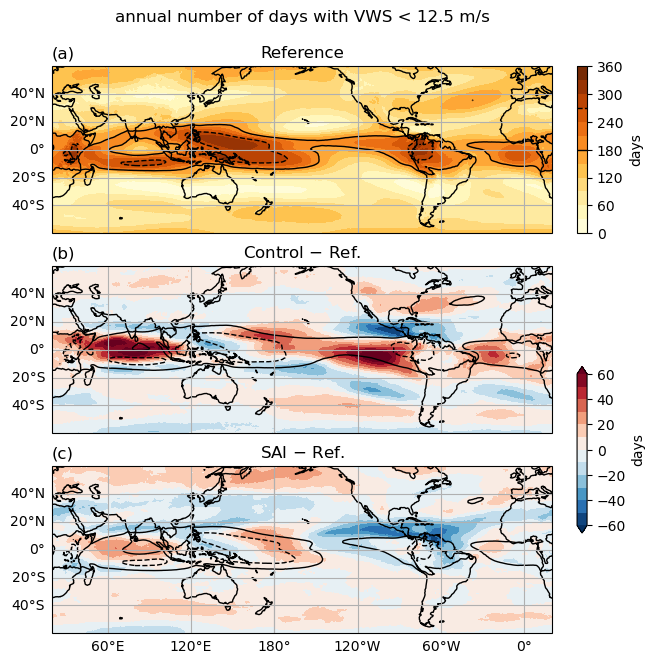

In [14]:
data = ds.lowVWSdays.sel(lat=slice(-60,60)).sum('month')
fig, axs = plt.subplots(3, 1, figsize=(5,3.4/3*5), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})
axs = axs.flatten()
for i,exp in enumerate(data.exp):
    datai = data.sel(exp=exp)
    if i > 0:
        cf = axs[i].contourf(datai.lon, datai.lat, datai-data.sel(exp='ref'), 
            transform=ccrs.PlateCarree(), levels=range(-60,61,10), extend='both', cmap='RdBu_r')
    else:
        cfr = axs[i].contourf(datai.lon, datai.lat, datai, 
            transform=ccrs.PlateCarree(), levels=range(0,366,30), cmap='YlOrBr')
    cs = axs[i].contour(datai.lon, datai.lat, datai, transform=ccrs.PlateCarree(), levels=[180,270], colors='k', linewidths=1, linestyles=['-','--'])
    cl = axs[i].coastlines()
    gl = axs[i].gridlines(draw_labels=(['left'] if i<2 else ['left','bottom']))
    axs[i].set_title({'ref':'Reference','cnt':'Control $-$ Ref.','sai':'SAI $-$ Ref.'}[exp.item()])
    axs[i].set_title(['(a)','(b)','(c)'][i], loc='left')
    axs[i].set_extent((20,380,-60,60), crs=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0, top=1, left=0, right=1,
                    wspace=0.2, hspace=0.2)
cbr_ax = fig.add_axes([1.05, 1-1/3.4, 0.02, 1/3.4])
cb_ax = fig.add_axes([1.05, 0.6/3.4, 0.02, 1/3.4])
cbr = fig.colorbar(cfr, cax=cbr_ax, ticks=cfr.levels[::2], label='days')
cb = fig.colorbar(cf, cax=cb_ax, ticks=cf.levels[::2], shrink=0.5, label='days')
cbr_ax.axhline(270, c='k', lw=1, ls='--')
cbr_ax.axhline(180, c='k', lw=1)

fig.suptitle('annual number of days with VWS < 12.5 m/s', y=1.1)
fig.savefig('../figures/VWS.lowdays.annualsum.pdf', transparent=True, bbox_inches='tight')

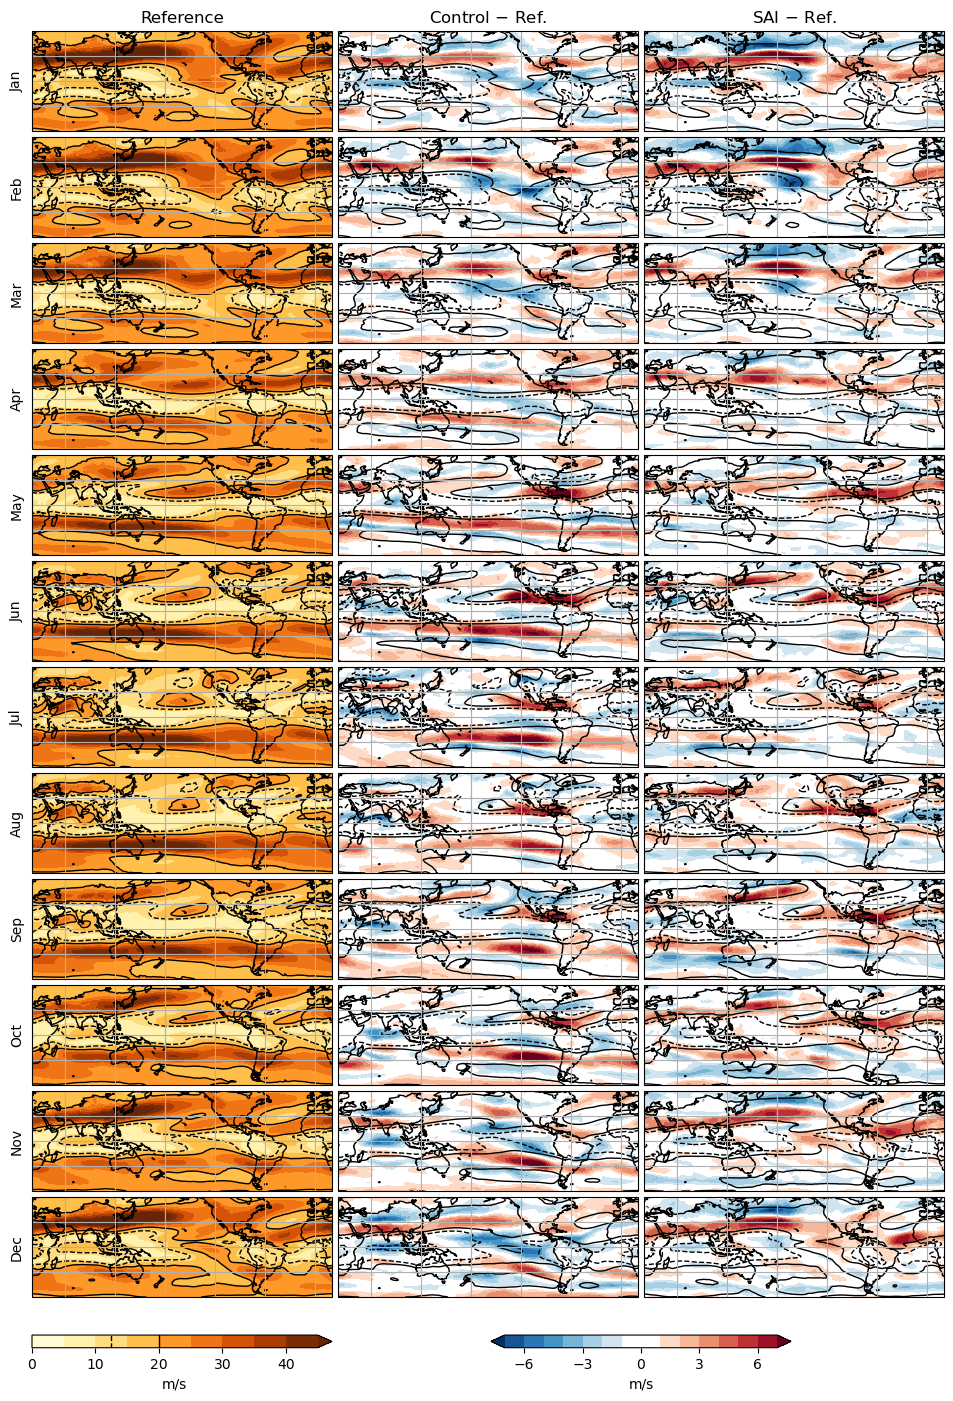

In [3]:
data = ds.VWS.sel(lat=slice(-60,60))

colors = plt.get_cmap('RdBu_r')(np.linspace(0,1,16))
colors[[7,8]] = [[1,1,1,1],[1,1,1,1]]
newcmap = mcolors.ListedColormap(colors[1:-1])
newcmap.set_over(colors[-1])
newcmap.set_under(colors[0])

fig, axs = plt.subplots(12, 3, figsize=(9.12,12.66), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

for m,mon in enumerate(data.month):
    for i,exp in enumerate(data.exp):
        datai = data.sel(exp=exp, month=mon)
        if i > 0:
            cf = axs[m,i].contourf(datai.lon, datai.lat, datai-data.sel(exp='ref', month=mon), 
                transform=ccrs.PlateCarree(), levels=range(-7,8,1), cmap=newcmap, extend='both')
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cf.set_rasterized(True)
        else:
            cfr = axs[m,i].contourf(datai.lon, datai.lat, datai, 
                transform=ccrs.PlateCarree(), levels=range(0,46,5), cmap='YlOrBr', extend='max')
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cfr.set_rasterized(True)
        cs = axs[m,i].contour(datai.lon, datai.lat, datai, transform=ccrs.PlateCarree(), levels=[12.5,20], colors='k', linewidths=1, linestyles=['--','-'])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cs.set_rasterized(True)
        cl = axs[m,i].coastlines()
        gl = axs[m,i].gridlines(ylocs=range(-60,61,30), xlocs=range(-180,181,60), crs=ccrs.PlateCarree())
        axs[m,i].set_extent((20,380,-60,60), crs=ccrs.PlateCarree())

for e,exp in enumerate(data.exp):
    axs[0,e].set_title(['Reference','Control $-$ Ref.','SAI $-$ Ref.'][e])

fig.subplots_adjust(bottom=0, top=1, left=0, right=1,
                    wspace=0.02, hspace=0.06)
cbr_ax = fig.add_axes([0, -0.04, 3/9.12, 0.01])
cb_ax = fig.add_axes([4.59/9.12, -0.04, 3/9.12, 0.01])
cbr = fig.colorbar(cfr, cax=cbr_ax, ticks=range(0,41,10), orientation='horizontal', label='m/s')
cb = fig.colorbar(cf, cax=cb_ax, ticks=range(-6,7,3), orientation='horizontal', label='m/s')
cbr_ax.axvline(12.5, c='k', lw=1, ls='--')
cbr_ax.axvline(20, c='k', lw=1)

for m,ax in enumerate(axs[:,0]):
    bbox = ax.get_position()
    fig.text(bbox.x0-0.05*(bbox.x1-bbox.x0),(bbox.y0+bbox.y1)/2,['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][m], ha='center', va='center', rotation=90)

fig.suptitle('monthly mean VWS', y=1.05)
fig.savefig('../figures/VWS.monmean.pdf', dpi=120, transparent=True, bbox_inches='tight')

/scratch-local/55013/ipykernel_3166727/3801574835.py:41: UserWarning: Adding colorbar to a different Figure <Figure size 912x1266 with 38 Axes> than <Figure size 912x1266 with 38 Axes> which fig.colorbar is called on.
  cbr = fig.colorbar(cfr, cax=cbr_ax, ticks=range(0,31,10), orientation='horizontal', label='days')
/scratch-local/55013/ipykernel_3166727/3801574835.py:42: UserWarning: Adding colorbar to a different Figure <Figure size 912x1266 with 38 Axes> than <Figure size 912x1266 with 38 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(cf, cax=cb_ax, ticks=range(-6,7,3), orientation='horizontal', label='days')


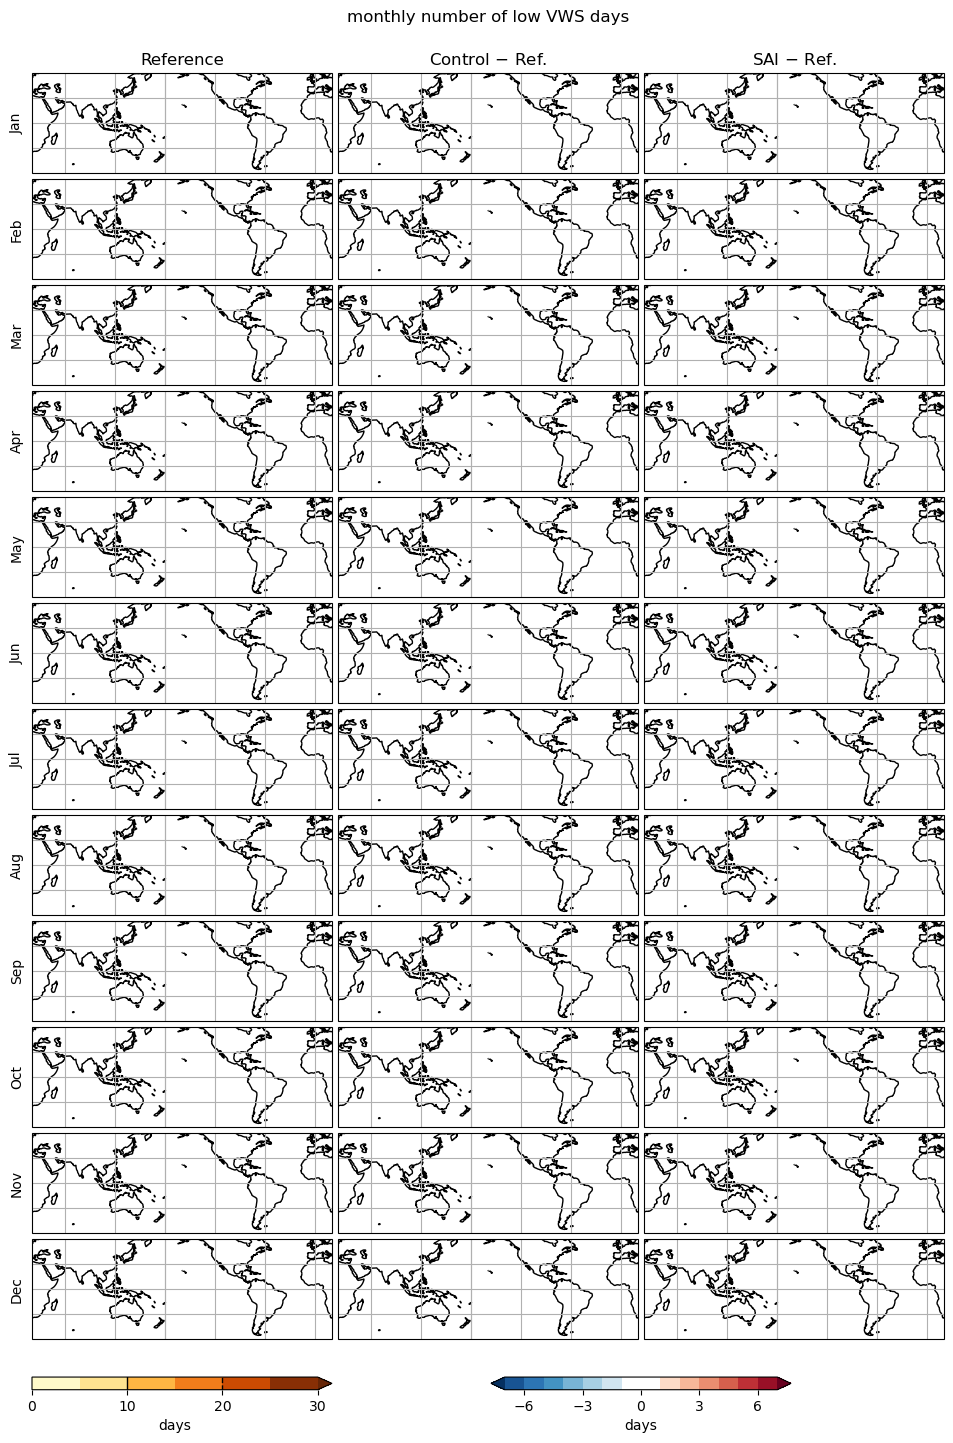

In [20]:
data = ds.lowVWSdays.sel(lat=slice(-60,60))

colors = plt.get_cmap('RdBu_r')(np.linspace(0,1,16))
colors[[7,8]] = [[1,1,1,1],[1,1,1,1]]
newcmap = mcolors.ListedColormap(colors[1:-1])
newcmap.set_over(colors[-1])
newcmap.set_under(colors[0])

fig, axs = plt.subplots(12, 3, figsize=(9.12,12.66), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=200)})

for m,mon in enumerate(data.month[:]):
    for i,exp in enumerate(data.exp):
        datai = data.sel(exp=exp, month=mon)
        if i > 0:
            cf = axs[m,i].contourf(datai.lon, datai.lat, datai-data.sel(exp='ref', month=mon), 
                transform=ccrs.PlateCarree(), levels=range(-7,8,1), cmap=newcmap, extend='both')
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cf.set_rasterized(True)
        else:
            cfr = axs[m,i].contourf(datai.lon, datai.lat, datai, 
                transform=ccrs.PlateCarree(), levels=range(0,32,5), cmap='YlOrBr', extend='max')
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                cfr.set_rasterized(True)
        cs = axs[m,i].contour(datai.lon, datai.lat, datai, transform=ccrs.PlateCarree(), levels=[10,20], colors='k', linewidths=1, linestyles=['-','--'])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cs.set_rasterized(True)
        cl = axs[m,i].coastlines()
        gl = axs[m,i].gridlines(ylocs=range(-60,61,30), xlocs=range(-180,181,60), crs=ccrs.PlateCarree())
        axs[m,i].set_extent((20,380,-60,60), crs=ccrs.PlateCarree())

for e,exp in enumerate(data.exp):
    axs[0,e].set_title(['Reference','Control $-$ Ref.','SAI $-$ Ref.'][e])

fig.subplots_adjust(bottom=0, top=1, left=0, right=1,
                    wspace=0.02, hspace=0.06)
cbr_ax = fig.add_axes([0, -0.04, 3/9.12, 0.01])
cb_ax = fig.add_axes([4.59/9.12, -0.04, 3/9.12, 0.01])
cbr = fig.colorbar(cfr, cax=cbr_ax, ticks=range(0,31,10), orientation='horizontal', label='days')
cb = fig.colorbar(cf, cax=cb_ax, ticks=range(-6,7,3), orientation='horizontal', label='days')
cbr_ax.axvline(10, c='k', lw=1)
cbr_ax.axvline(20, c='k', lw=1, ls='--')

for m,ax in enumerate(axs[:,0]):
    bbox = ax.get_position()
    fig.text(bbox.x0-0.05*(bbox.x1-bbox.x0),(bbox.y0+bbox.y1)/2,['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'][m], ha='center', va='center', rotation=90)

fig.suptitle('monthly number of low VWS days', y=1.05)
fig.savefig('../figures/VWS.lowdays.monmean.pdf', dpi=120, transparent=True, bbox_inches='tight')

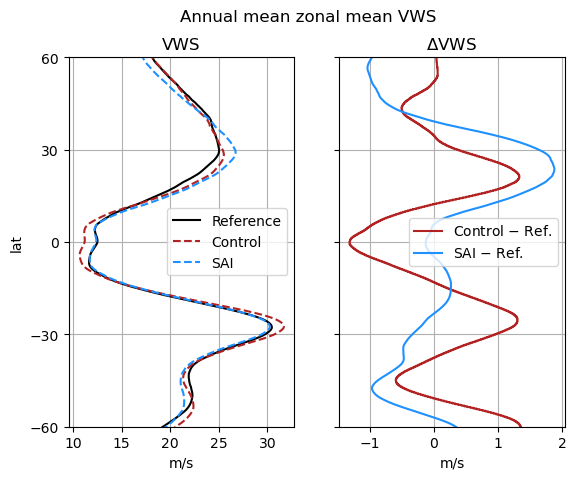

In [29]:
data = ds.VWS.weighted(ds.dpm).mean(('month','lon'))

fig,axs = plt.subplots(1,2, sharey=True, subplot_kw={'ylim':[-60,60], 'yticks':range(-60,61,30)})

ax = axs[0]
data.sel(exp='ref').plot(ax=ax, y='lat', c='k', label='Reference')
data.sel(exp='cnt').plot(ax=ax, y='lat', c='firebrick', ls='--', label='Control')
data.sel(exp='sai').plot(ax=ax, y='lat', c='dodgerblue', ls='--', label='SAI')
ax.grid()
ax.legend()
ax.set_title('VWS')
ax.set_xlabel('m/s')

ax = axs[1]
(data.sel(exp='cnt')-data.sel(exp='ref')).plot.step(ax=ax, y='lat', c='firebrick', label='Control $-$ Ref.')
(data.sel(exp='sai')-data.sel(exp='ref')).plot(ax=ax, y='lat', c='dodgerblue', label='SAI $-$ Ref.')
ax.set_ylabel('')
ax.legend()
ax.grid()
ax.set_title(r'$\Delta$VWS')
ax.set_xlabel('m/s')

fig.suptitle('Annual mean zonal mean VWS')
fig.savefig('../figures/VWSzm.annualmean.pdf', transparent=True, bbox_inches='tight')

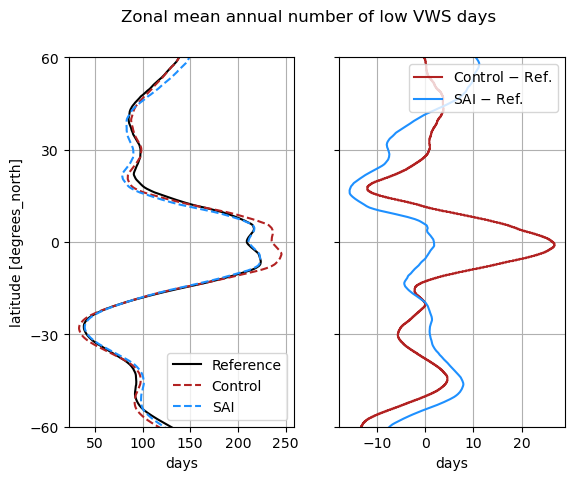

In [25]:
data = ds.lowVWSdays.sum('month').mean('lon')

fig,axs = plt.subplots(1,2, sharey=True, subplot_kw={'ylim':[-60,60], 'yticks':range(-60,61,30)})

ax = axs[0]
data.sel(exp='ref').plot(ax=ax, y='lat', c='k', label='Reference')
data.sel(exp='cnt').plot(ax=ax, y='lat', c='firebrick', ls='--', label='Control')
data.sel(exp='sai').plot(ax=ax, y='lat', c='dodgerblue', ls='--', label='SAI')
ax.grid()
ax.legend()
ax.set_xlabel('days')
ax.set_title('')

ax = axs[1]
(data.sel(exp='cnt')-data.sel(exp='ref')).plot.step(ax=ax, y='lat', c='firebrick', label='Control $-$ Ref.')
(data.sel(exp='sai')-data.sel(exp='ref')).plot(ax=ax, y='lat', c='dodgerblue', label='SAI $-$ Ref.')
ax.set_ylabel('')
ax.legend(loc='upper right')
ax.grid()
ax.set_xlabel('days')

fig.suptitle('Zonal mean annual number of low VWS days')
fig.savefig('../figures/VWSzm.lowdays.annualsum.pdf', transparent=True, bbox_inches='tight')

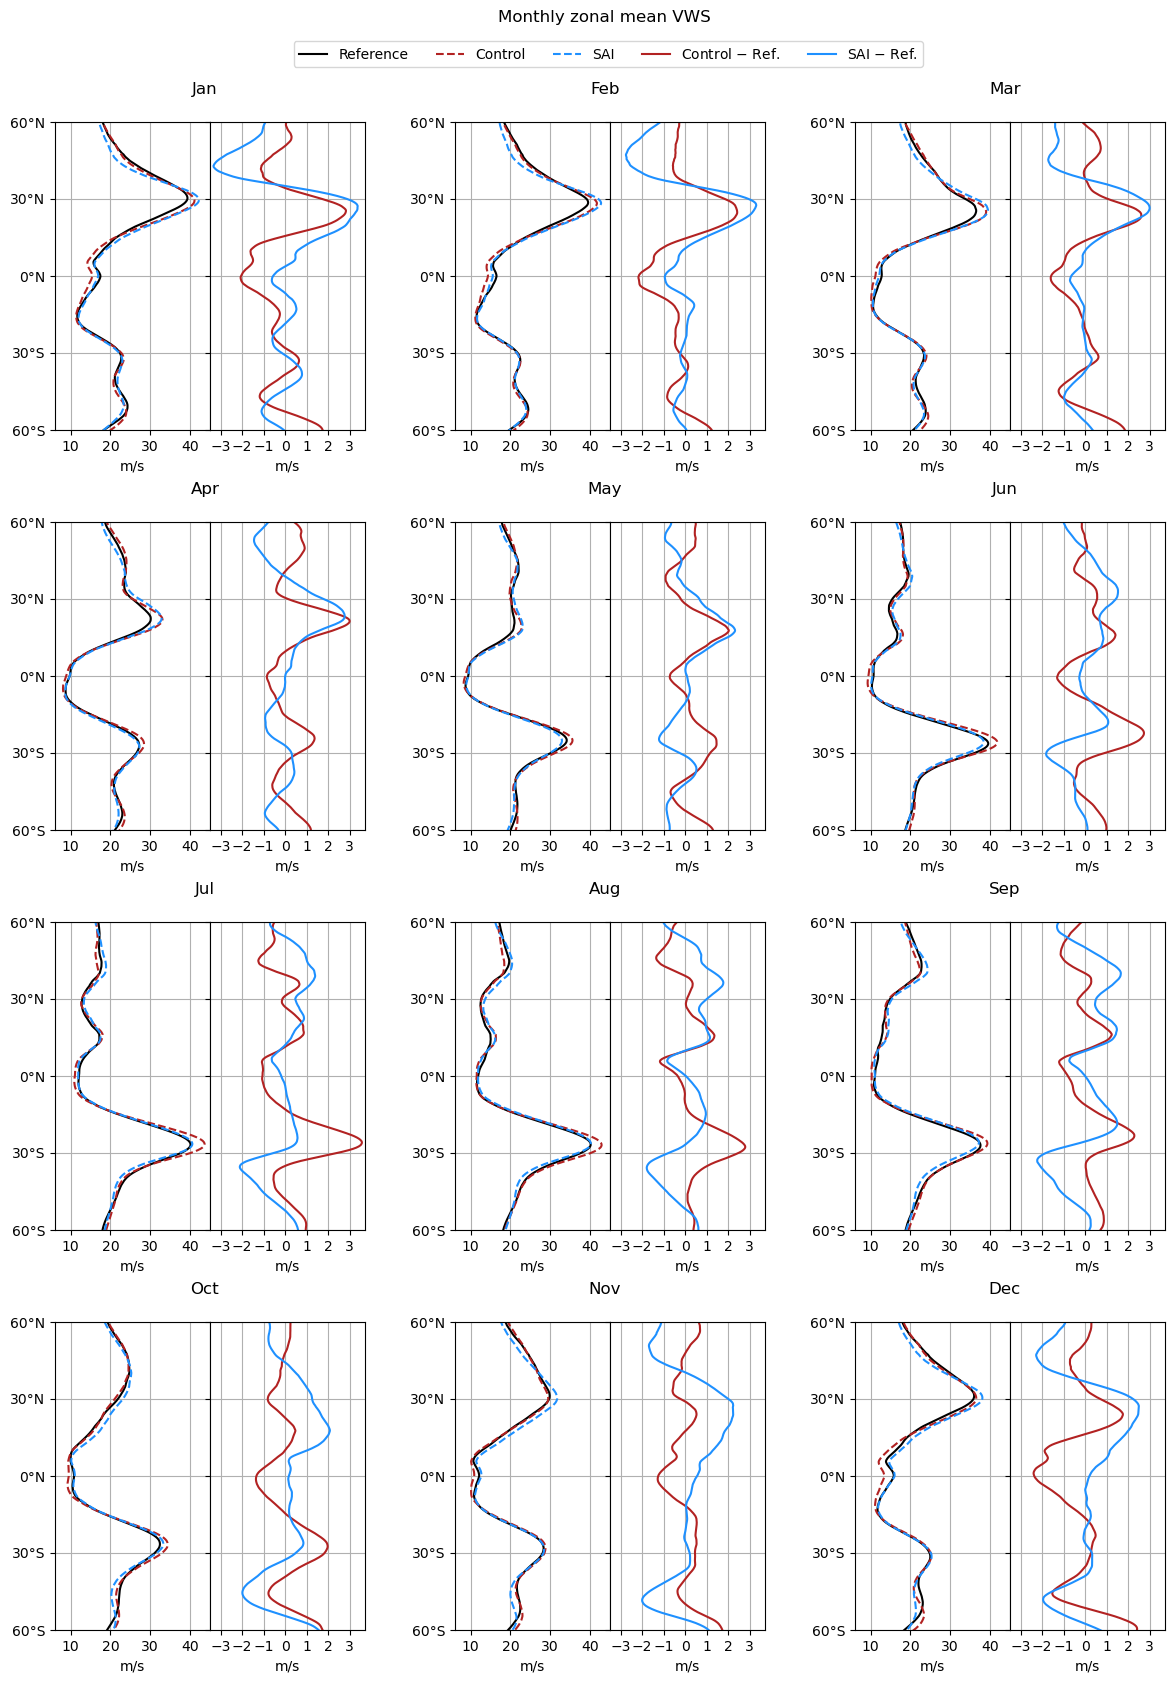

In [3]:
data = ds.VWS.mean('lon')
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig,axs = plt.subplots(4,3, figsize=(12,16))
gs = axs[0,0].get_subplotspec().get_gridspec()
axs = axs.flatten()

for m,month in enumerate(months):
    mondata = data.isel(month=m)
    axs[m].remove()
    subfig = fig.add_subfigure(gs[m])
    subfig.suptitle(month)
    ax1,ax2 = subfig.subplots(1,2, sharey=True)
    
    mondata.sel(exp='ref').plot(ax=ax1, y='lat', c='k')
    mondata.sel(exp='cnt').plot(ax=ax1, y='lat', c='firebrick', ls='--')
    mondata.sel(exp='sai').plot(ax=ax1, y='lat', c='dodgerblue', ls='--')
    ax1.set_xlim([6,45])
    ax1.set_ylim([-60,60])
    ax1.grid()
    ax1.set_xticks(range(10,41,10))
    ax1.set_yticks(range(-60,61,30), labels=['60°S','30°S','0°N','30°N','60°N'])
    ax1.set_title('')
    ax1.set_xlabel('m/s')
    ax1.set_ylabel('')

    (mondata.sel(exp='cnt')-mondata.sel(exp='ref')).plot(ax=ax2, y='lat', c='firebrick')
    (mondata.sel(exp='sai')-mondata.sel(exp='ref')).plot(ax=ax2, y='lat', c='dodgerblue')
    ax2.set_xlim([-3.7,3.7])
    ax2.grid()
    ax2.set_xticks(range(-3,4,1))
    ax2.set_xlabel('m/s')
    ax2.set_ylabel('')
    ax2.set_title('')

fig.subplots_adjust(wspace=0.0)
fig.suptitle('Monthly zonal mean VWS', y=1.04)
fig.legend(['Reference','Control','SAI','Control $-$ Ref.','SAI $-$ Ref.'], ncols=5, loc=(0.25,0.96))
fig.savefig('../figures/VWSzm.monmean.pdf', transparent=True, bbox_inches='tight')

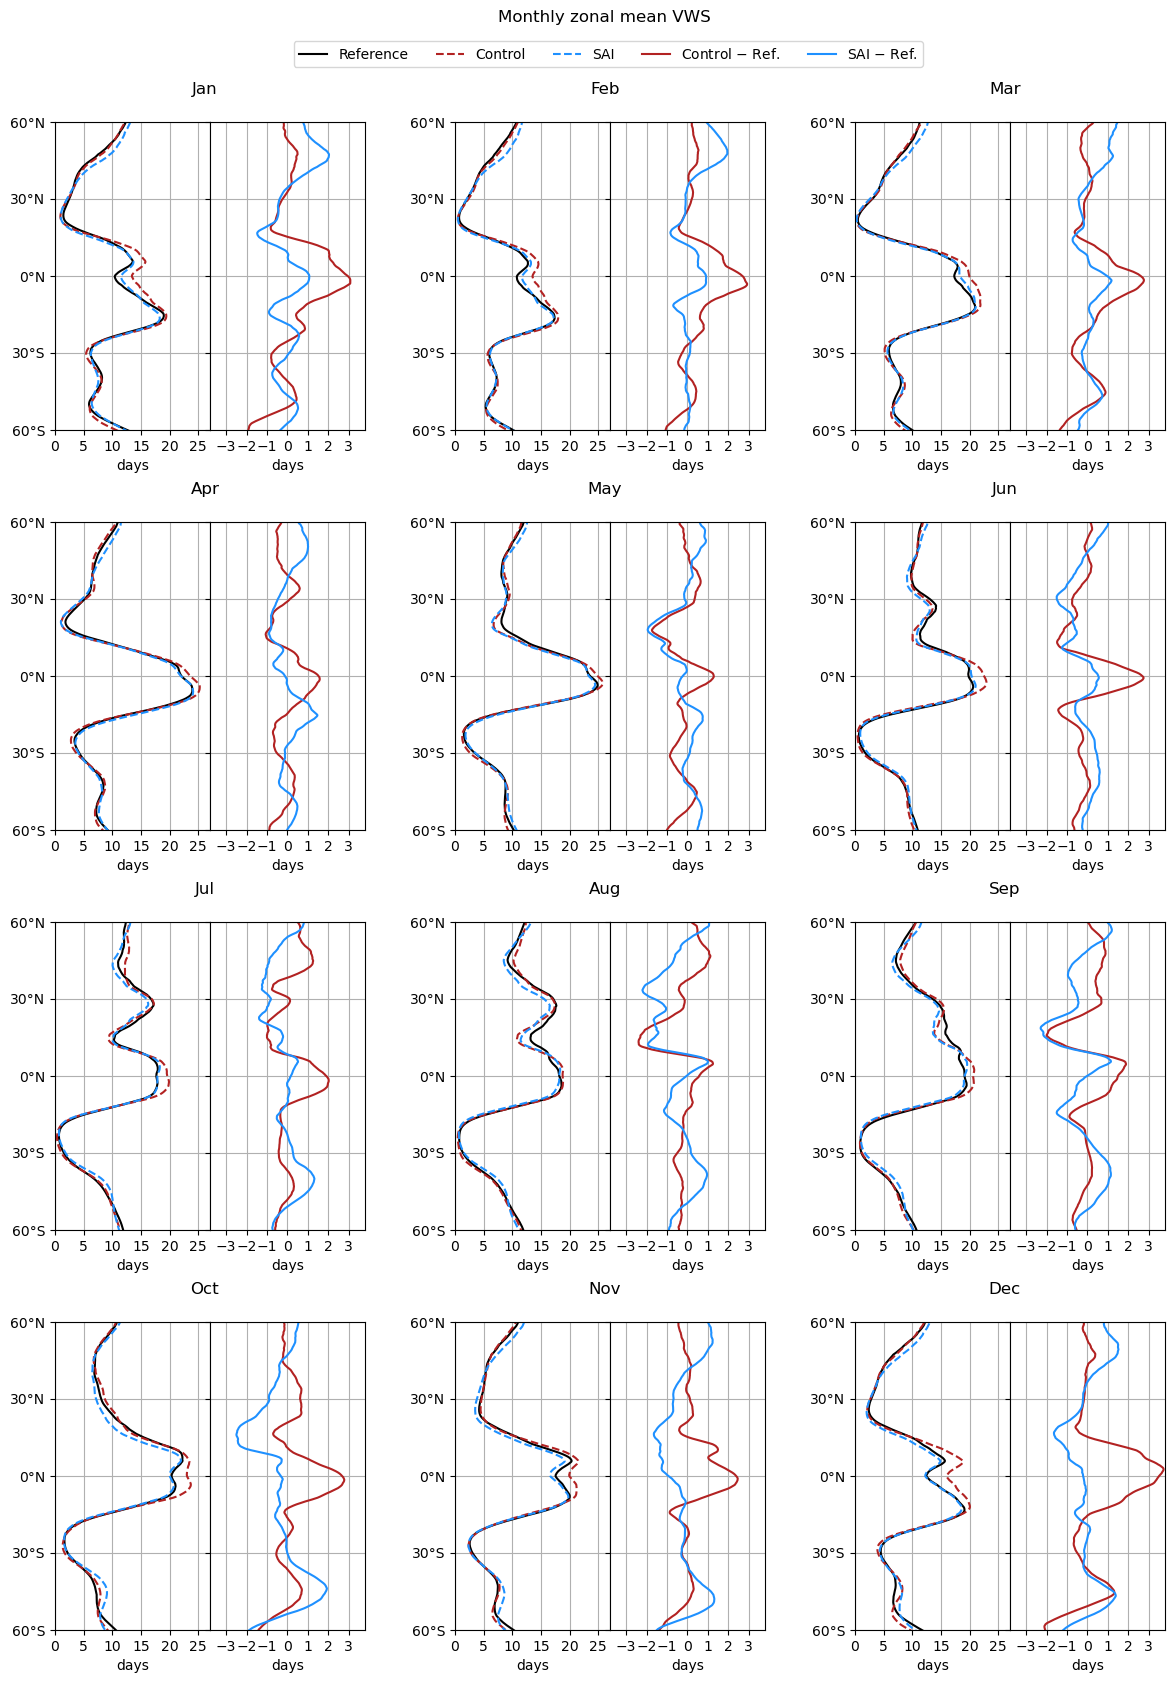

In [30]:
data = ds.lowVWSdays.mean('lon')
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

fig,axs = plt.subplots(4,3, figsize=(12,16))
gs = axs[0,0].get_subplotspec().get_gridspec()
axs = axs.flatten()

for m,month in enumerate(months):
    mondata = data.isel(month=m)
    axs[m].remove()
    subfig = fig.add_subfigure(gs[m])
    subfig.suptitle(month)
    ax1,ax2 = subfig.subplots(1,2, sharey=True)
    
    mondata.sel(exp='ref').plot(ax=ax1, y='lat', c='k')
    mondata.sel(exp='cnt').plot(ax=ax1, y='lat', c='firebrick', ls='--')
    mondata.sel(exp='sai').plot(ax=ax1, y='lat', c='dodgerblue', ls='--')
    ax1.set_xlim([0,27])
    ax1.set_ylim([-60,60])
    ax1.grid()
    ax1.set_xticks(range(0,26,5))
    ax1.set_yticks(range(-60,61,30), labels=['60°S','30°S','0°N','30°N','60°N'])
    ax1.set_title('')
    ax1.set_xlabel('days')
    ax1.set_ylabel('')

    (mondata.sel(exp='cnt')-mondata.sel(exp='ref')).plot(ax=ax2, y='lat', c='firebrick')
    (mondata.sel(exp='sai')-mondata.sel(exp='ref')).plot(ax=ax2, y='lat', c='dodgerblue')
    ax2.set_xlim([-3.8,3.8])
    ax2.grid()
    ax2.set_xticks(range(-3,4,1))
    ax2.set_xlabel('days')
    ax2.set_ylabel('')
    ax2.set_title('')

fig.subplots_adjust(wspace=0.0)
fig.suptitle('Monthly zonal mean VWS', y=1.04)
fig.legend(['Reference','Control','SAI','Control $-$ Ref.','SAI $-$ Ref.'], ncols=5, loc=(0.25,0.96))
fig.savefig('../figures/VWSzm.lowdays.monmean.pdf', transparent=True, bbox_inches='tight')

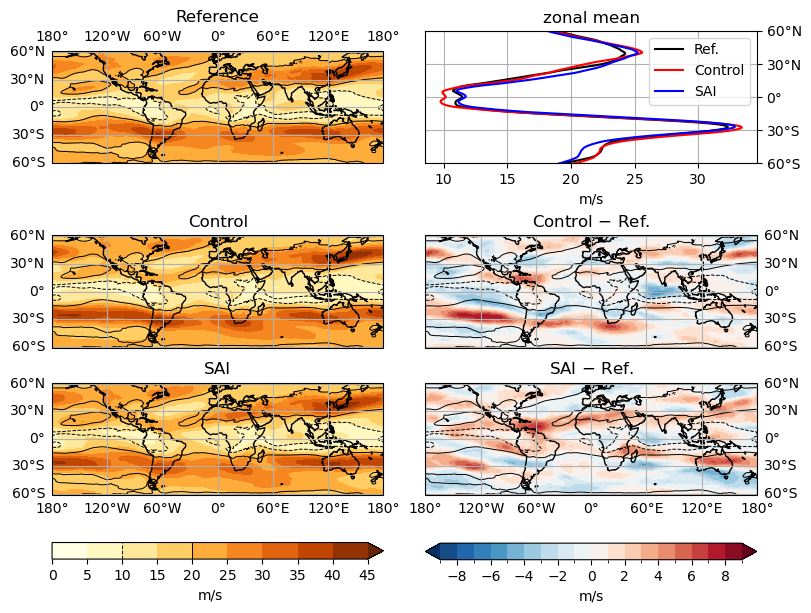

In [40]:
fig,axs = plt.subplots(3,2,figsize=(8,6),layout='constrained',subplot_kw={'projection':ccrs.PlateCarree()})

VWS = {exp: ds_VWS.VWS.sel(exp=exp, month=[9,10,11]).mean('month') for exp in ds_VWS.exp.data}

titles = {'ref': 'Reference', 'cnt': 'Control', 'sai': 'SAI'}
for ax,exp in zip(axs[:,0],ds_VWS.exp.data):
    p = VWS[exp].plot.contourf(ax=ax, levels=range(0,46,5), cmap='YlOrBr', extend='max', transform=ccrs.PlateCarree(), add_colorbar=False)
    VWS['ref'].plot.contour(ax=ax, levels=[10,20], transform=ccrs.PlateCarree(), colors='k', linewidths=0.7, linestyles=['--','-'])
    ax.coastlines()
    ax.set_title(titles[exp])
    ax.set_extent((-180,180,-61,61), crs=ccrs.PlateCarree())

for ax,exp in zip(axs[1:,1],['cnt','sai']):
    pd = (VWS[exp]-VWS['ref']).plot.contourf(
        ax=ax, levels=range(-9,10,1), extend='both', transform=ccrs.PlateCarree(), add_colorbar=False)
    VWS['ref'].plot.contour(ax=ax, levels=[10,20], transform=ccrs.PlateCarree(), colors='k', linewidths=0.7, linestyles=['--','-'])
    ax.coastlines()
    ax.set_title(f'{titles[exp]} $-$ Ref.')
    ax.set_extent((-180,180,-61,61), crs=ccrs.PlateCarree())


axs[0,0].gridlines(xlocs=range(-180,181,60), ylocs=range(-60,61,30), draw_labels=['top','left'])
axs[1,0].gridlines(xlocs=range(-180,181,60), ylocs=range(-60,61,30), draw_labels=['left'])
axs[2,0].gridlines(xlocs=range(-180,181,60), ylocs=range(-60,61,30), draw_labels=['bottom','left'])
axs[1,1].gridlines(xlocs=range(-180,181,60), ylocs=range(-60,61,30), draw_labels=['right'])
axs[2,1].gridlines(xlocs=range(-180,181,60), ylocs=range(-60,61,30), draw_labels=['bottom','right'])

fig.delaxes(axs[0,1])
ax = fig.add_subplot(322)
VWS['ref'].mean('lon').plot(ax=ax, c='k', y='lat', label='Ref.')
VWS['cnt'].mean('lon').plot(ax=ax, c='r', y='lat', label='Control')
VWS['sai'].mean('lon').plot(ax=ax, c='b', y='lat', label='SAI')
ax.set_yticks(range(-60,61,30), labels=['60°S','30°S','0°','30°N','60°N'])
ax.set_xlabel('m/s')
ax.set_ylabel('')
ax.set_ylim([-60,60])
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.set_title('zonal mean')
ax.grid()
ax.legend()

cb = fig.colorbar(p, ax=axs[:,0], orientation='horizontal', label='m/s')
cbd = fig.colorbar(pd, ax=axs[1:,1], orientation='horizontal', label='m/s', pad=0.09)
cb.ax.axvline(10, ls='--', c='k', lw=0.7)
cb.ax.axvline(20, ls='-', c='k', lw=0.7)

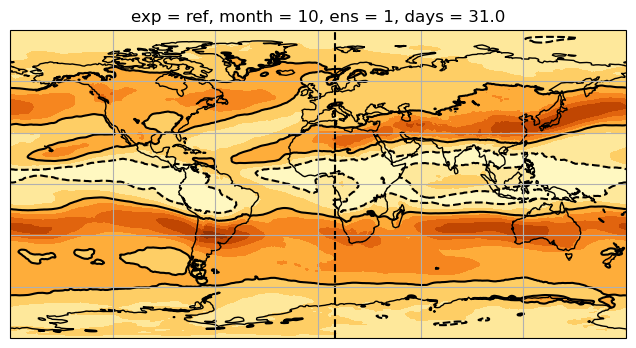

In [38]:
plt.figure(figsize=(8,4))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.axvline(10, ls='--', c='k')
ds_VWS.VWS.sel(exp= 'ref', month=10).plot.contourf(ax=ax, levels=range(0,46,5), cmap='YlOrBr', extend='max', transform=ccrs.PlateCarree(), add_colorbar=False)
#ds_VWS.VWS.sel(exp='cnt', month=10).plot.contour(levels=range(0,46,5), colors='k', linewidths=0.3)
ds_VWS.VWS.sel(exp='ref', month=10).plot.contour(ax=ax, levels=[10,20], colors='k', linestyles=['--','-'])
ax.coastlines()
ax.gridlines()